In [9]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image   

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

Визуализация
    

def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    

In [10]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
    

Датасет

In [11]:

class SiameseNetworkDataset(Dataset):
    # инициализация класса
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
     # метод для чтения изображений    
    def __getitem__(self,index):
        # читаем случайное изображений из базы данных
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #Для качественног обучения, необходимо полчить приблизительно
        # 50% изображений одного класса 
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                # ищем изображение в том же классе
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                # ищем изображение из другого класса
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break
                    
        # читаем изображение
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        # преобразование к яркости
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        # если применяем трасформацию
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        # выход - 2 изображения и метки (один класс или разный)
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    

In [12]:
# dataset: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
folder_dataset = datasets.ImageFolder(root="data/faces/training/")

# Преобразование к тензору
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Инициализация пользовательского датасета
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)


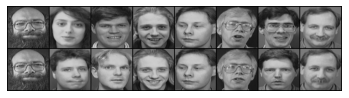

[0. 1. 1. 0. 0. 0. 1. 0.]


In [13]:
# DataLoader - сборка пакета
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# извлекаем пакет
example_batch = next(iter(vis_dataloader))

# Пример пакета - список, содержащий 2x8 изображений, индексы 0 и 1, а также метку
# Если метка равна 1, это означает, что это разные люди, метка равна 0,
# один и тот же человек на обоих изображениях
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))



In [14]:
# Пользовательская сеть
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Sequential - сборка (стекинг) слоев в один объект - последовательность
        self.cnn1 = nn.Sequential(
            # 96 cверток размером 11х11 и шагом 4
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Полносвязный слой
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            # кодируем изображение в пространство размерности 256
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # Эта функция будет вызвана для обоих изображений 
        # Ее результат используется для определения сходства
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # В этой функции мы передаем 2 изображения и получаем 2 вектора которые возвращаются
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2
    

In [15]:
# функция ошибки
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # евклидово расстояние и contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive
    
    

In [17]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

net = SiameseNetwork()#.cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Epoch number 0
 Current loss 1.9980816841125488

Epoch number 1
 Current loss 1.2755306959152222

Epoch number 2
 Current loss 1.193748950958252

Epoch number 3
 Current loss 1.0135347843170166

Epoch number 4
 Current loss 0.9299558401107788

Epoch number 5
 Current loss 0.8581987619400024

Epoch number 6
 Current loss 0.8364483118057251

Epoch number 7
 Current loss 0.6866704821586609

Epoch number 8
 Current loss 0.6457270979881287

Epoch number 9
 Current loss 0.965848445892334



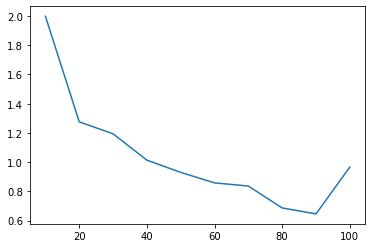

In [18]:
loss_history = [] 
iteration_number= 0
counter = []

# итерации по эпохам
for epoch in range(10):

    # итерации по пакетам
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # если есть cuda, отправляем туда
       # img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # обнудение градиента
        optimizer.zero_grad()

        # на вход сети 2 изображения, на выход 2 вектора (размером 256)
        # forward 
        output1, output2 = net(img0, img1)

        # передаем изображения и метку в loss function
        loss_contrastive = criterion(output1, output2, label)

        #  Обратное распостранение ошибки (backward pass)
        loss_contrastive.backward()

        # Оптимизация
        optimizer.step()

        # Каждые 10 итераций выводим loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)


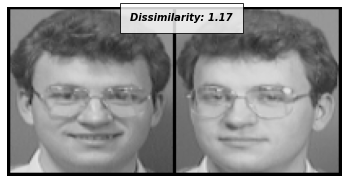

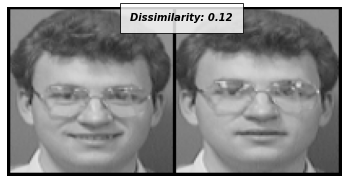

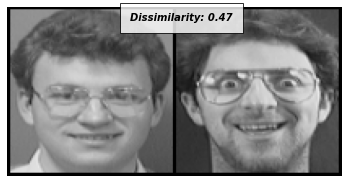

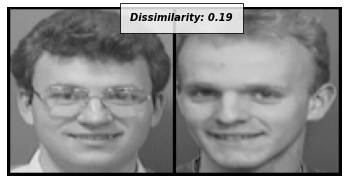

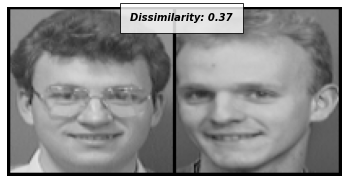

In [23]:
# Тест
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Извлекаем одно изображение для теста
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(5):
    # Итеративно сравниваем исходное изображение с 5 изображениями
    _, x1, label2 = next(dataiter)

    # Конкатенация 2-х изображений
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0, x1) # net(x0.cuda(), x1.cuda())
    # расстояние между изображениями
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
